In [1]:
import cdflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from kamodo_ccmc.flythrough.utils import ConvertCoord
from datetime import datetime, timezone, timedelta
import re
from pylab import rcParams
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D
import json
import configparser
import requests
import time

r_e = 6371.

data = xr.open_dataset("fgm.nc")

conj = pd.read_pickle('whi_conj_200.pkl')

In [2]:
buffer = 180 # in seconds
sat_id = 29678
index = conj.index[conj['sat-ID'] == str(sat_id)][0]

p_int = 100 # data point interval for magnetic field line plotting

conj_time = conj['conj-time'].iloc[index]

sta = conj_time - timedelta(seconds=buffer)
end = conj_time + timedelta(seconds=buffer)

spec = data.sel(t=slice(sta,end))
maxb = np.max(spec['bvec'].values)*1.1

t = spec['t']
t1 = pd.to_datetime(spec['t'].values[0]).round('s')
t2 = pd.to_datetime(spec['t'].values[-1]).round('s')

bx = spec['bvec'].values[:,0]
by = spec['bvec'].values[:,1]
bz = spec['bvec'].values[:,2]
bmag = spec['bvec'].values[:,3]

x = spec['bvec'].values[:,4]
y = spec['bvec'].values[:,5]
z = spec['bvec'].values[:,6]

Text(0.5, 1.0, '2011-11-01 21:47:58 to 2011-11-01 21:53:58')

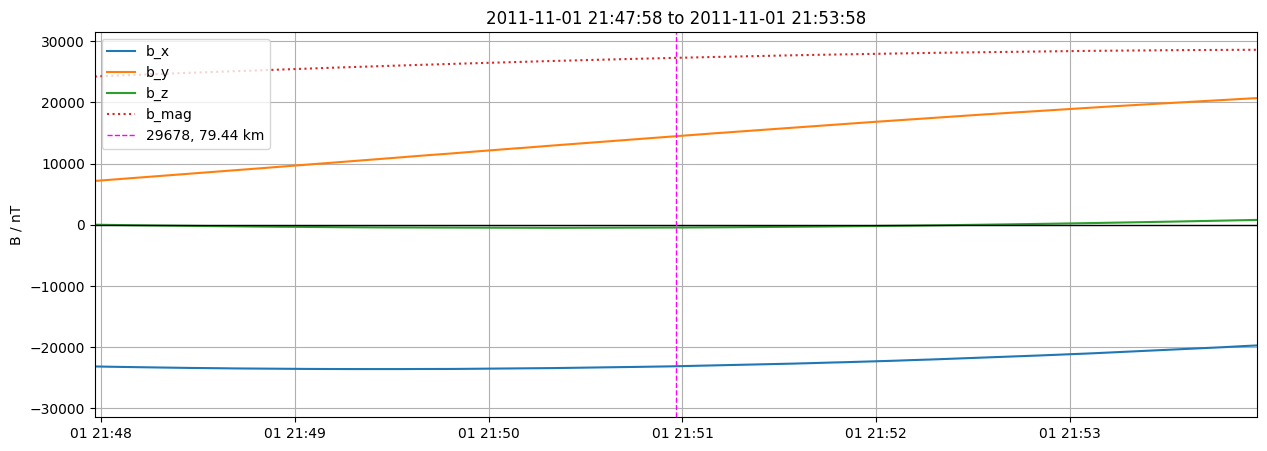

In [3]:
rcParams['figure.figsize'] = 15, 5

plt.plot(t,bx,label='b_x')
plt.plot(t,by,label='b_y')
plt.plot(t,bz,label='b_z')
plt.plot(t,bmag,label='b_mag',ls=':')

plt.xlim(spec['t'].values[0],spec['t'].values[-1])
plt.ylim(-maxb, maxb)
plt.ylabel('B / nT')
plt.axhline(0, lw=1, color='black')
plt.axvline(x = conj['conj-time'].iloc[index],lw=1,ls='--',color='magenta',label = str(conj['sat-ID'].iloc[index]) + ', ' + str(round(conj['conj-dist'].iloc[index], 2)) + ' km')
plt.grid()
plt.legend()
plt.title(str(t1) + ' to ' + str(t2))

The cell below obtains values for the geomagnetic field according to the 13th gen International Geomagnetic Reference Field (IGRF) for the date of conjunction, and calculates a directional vector for the field at each supplied position in GSE coordinates. The [IGRF calculator](https://geomag.bgs.ac.uk/data_service/models_compass/igrf_calc.html) supplied by the BGS works in geodetic coordinates (GDZ) (lat/deg, lon/deg, alt/km) and so it is necessary to transform from Cartesian GSE to spherical GDZ and back. The IGRF calculator supplies a vertical intensity, positive downwards, and north and east intensities, comparable to latitude and longitude respectively. The code below does a sort of stupid roundabout way of transforming the vector between coordinate systems, by representing a vector as a tiny physical line whose origin is at the sampled position. The endpoint is transformed back to GSE. The resultant vector is simply the difference between this transformed endpoint and the original GSE position. 

In [4]:
cc_gdz_time = np.array(pd.to_datetime(t.values).values.tolist())*(10**-9)
lon_gdz, lat_gdz, al_gdz, units = ConvertCoord(cc_gdz_time[::p_int], (x/r_e)[::p_int], (y/r_e)[::p_int], (z/r_e)[::p_int], 'GSE', 'car', 'GDZ', 'sph', verbose=False)

diff_lat = np.zeros(len(lon_gdz))
diff_lon = np.zeros(len(lon_gdz))
mag = np.zeros(len(lon_gdz))

diff_alt = 0.001 # in km, i.e. 1 m

eff_r = al_gdz + r_e

for i in range(len(lon_gdz)):
    r = requests.get('https://geomag.bgs.ac.uk/web_service/GMModels/igrf/13/?latitude=' + str(lat_gdz[i]) + '&longitude=' + str(lon_gdz[i]) + '&altitude=' + str(al_gdz[i]) + '&date=' + str(conj_time.date()) + '&format=json')
    load_field = json.loads(r.text)['geomagnetic-field-model-result']['field-value']
    vert = load_field['vertical-intensity']['value']
    n_prop = load_field['north-intensity']['value'] / vert
    e_prop = load_field['east-intensity']['value'] / vert
    diff_lat[i] = n_prop / (2 * np.pi * eff_r[i] / diff_alt) * 360
    diff_lon[i] = e_prop / (2 * np.pi * eff_r[i] * np.cos(lat_gdz[i]/180*np.pi) / diff_alt) * 360
    mag[i] = load_field['total-intensity']['value']

sec_lat = lat_gdz + diff_lat
sec_lon = lon_gdz + diff_lon

new_point = ConvertCoord(cc_gdz_time[::p_int], sec_lon, sec_lat, al_gdz - diff_alt, 'GDZ', 'sph', 'GSE', 'car')[:-1]
u_cc = new_point[0]*r_e - x[::p_int]
v_cc = new_point[1]*r_e - y[::p_int]
w_cc = new_point[2]*r_e - z[::p_int]

In [5]:
# difference between recorded magnitude and magnitude from model, in nT
bmag[::p_int] - mag

array([41.91992188, 43.609375  , 47.88085938, 45.52929688, 48.88085938,
       51.09960938, 49.66992188, 51.15039062, 51.59960938, 54.5703125 ,
       55.4296875 , 57.859375  , 57.609375  , 55.16015625, 58.11914062,
       59.66015625, 59.61914062, 63.66015625])

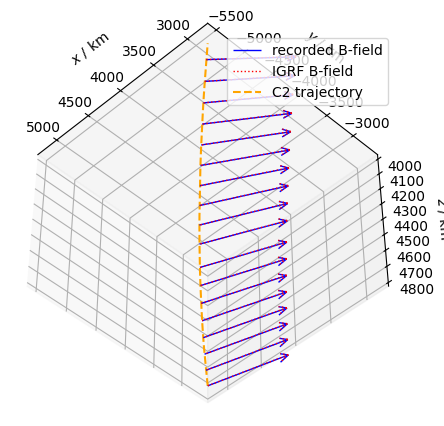

In [6]:
plt.figure()
ax = plt.axes(projection='3d')

plt.quiver(x[::p_int],y[::p_int],z[::p_int],bx[::p_int],by[::p_int],bz[::p_int],length=1000,arrow_length_ratio=0.1,normalize=True,color='blue',label='recorded B-field',linewidths=1)
plt.quiver(x[::p_int],y[::p_int],z[::p_int],u_cc,v_cc,w_cc,length=1000,arrow_length_ratio=0.1,normalize=True,color='red',linewidths=1,label='IGRF B-field',linestyles=':')
plt.plot(x,y,z,ls='--',c='orange',label='C2 trajectory')

ax.legend()
ax.set_xlabel('$x$ / km')
ax.set_ylabel('$y$ / km')
ax.set_zlabel('$z$ / km')

ax.view_init(135, 45)